<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod6/dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod6/dnn.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

Training Deep Neural Networks
---
_homl3 ch11_

- A DNN has 10 and more layers
- each layer contains hundreds of neurons linked by hundreds of thousands of connections
- i.e. there are hundreds of thousands even millions of parameters


Problems in training DNNs
---
- gradients growing ever smaller or larger during backpropagating the DNN
  - called the `vanishing and exploding gradients` problems
  - both make lower layers very hard to train
- `insufficient data` for such a large DNN,
  - or it might be too costly to label, e.x. 
  - can be tackled with `transfer learning and unsupervised pretraining`
- A model with millions of parameters would severely risk `overfitting` the training set
  - especially if there are not enough training instances 
  - or if they are too noisy
  - can be tackled with `regularization techniques`
- Training may be extremely `slow`
  - can be tackled with various `optimizers` that can speed up training large models tremendously

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

import tensorflow as tf, keras_tuner as kt

import sys

/opt/micromamba/envs/ml/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# The Vanishing and Exploding Gradients Problems
- the backprop backward step propagates the error gradient from the output layer to the input layer
  - computes the gradient of the cost function with regard to each parameter in the network
  - then uses these gradients to update each parameter with a gradient descent step
- Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers
  - As a result, the gradient descent update leaves the lower layers’ connection weights virtually unchanged
  - and training never converges to a good solution
  - This is called the `vanishing gradients problem`
- In some cases, the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges
  - This is the `exploding gradients problem`
  - often happens in recurrent neural networks
- More generally, DNNs suffer from `unstable gradients`
  - different layers may learn at widely different speeds

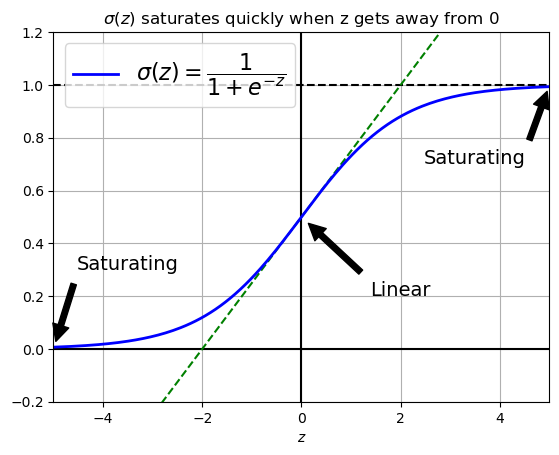

In [5]:
# 1. the sigmoid (logistic) activation function saturates quickly
#    when z gets away from 0 
#    i.e. the derivative gets very small

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

fig1, ax1 = plt.subplots()
ax1.plot([-5, 5], [0, 0], 'k-')
ax1.plot([-5, 5], [1, 1], 'k--')
ax1.plot([0, 0], [-0.2, 1.2], 'k-')
ax1.plot([-5, 5], [-3/4, 7/4], 'g--')
ax1.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
ax1.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
ax1.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
ax1.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
ax1.grid(True)
ax1.axis([-5, 5, -0.2, 1.2])
ax1.set_xlabel("$z$")
ax1.legend(loc="upper left", fontsize=16);
ax1.set_title(r"$\sigma(z)$" " saturates quickly when z gets away from 0");

Suspect caused the vanishing gradient problem
---
- the combination of sigmoid activation function and weight initialization technique ℕ(0,1)
  - causes the variance keeps increasing after each layer 
  - until the activation function saturates at the top layers
- this saturation is made worse due that 
  - the sigmoid function has a mean of 0.5, not 0
  - the hyperbolic tangent function has a mean of 0 
    - so it behaves slightly better than the sigmoid function
- ∴ there is almost no gradient to propagate back through the network
  - what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers
  - so there is really nothing left for the lower layers

Glorot or Xavier Initialization 
---
when using the `sigmoid` activation function, `Glorot initialization` significantly 
- alleviates the unstable gradients problem
  - speeds up training considerably 
  - becomes one of the practices that led to the success of deep learning
- initializes the weights of each layer randomly with
  - normal distribution: ${\displaystyle N(0,σ^2)}$ where  ${\displaystyle σ^2=\frac{1}{\operatorname{fan}_{avg}}}$, or
  - uniform distribution: ${\displaystyle {\displaystyle {\mathcal {U}}_{[-r,r]}}}$ where ${\displaystyle r=\sqrt{\dfrac{3}{\operatorname{fan}_{avg}}} = \sqrt{3}\sigma }$
  - ${\displaystyle \operatorname{fan}_{avg} = \dfrac{ \operatorname{fan}_{in}} {\operatorname{fan}_{out}}}$
  - the numbers of inputs and outputs of a layer are called the `fan-in` and `fan-out` of the layer
- `LeCun initialization` replaces $fan_{avg}$ with $fan_{in}$
  - equivalent to Glorot initialization when $fan_{in} = fan_{out}$

He Initialization 
---
- similar strategies have been proposed for different activation functions
  - they differ only by the scale of the variance and whether they use $fan_{avg}$ or $fan_{in}$
- The initialization strategy proposed for the `ReLU` activation function and its variants is called `He initialization` or `Kaiming initialization`
- Initialization parameters for each type of activation function

| Initialization |  Activation functions | σ² (Normal) |
|:--:|:--:|:--:|
| Glorot |  None, tanh, sigmoid, softmax |  $1 / fan_{avg}$ |
| He | ReLU, Leaky ReLU, ELU, GELU, Swish, Mish | $2 / fan_{in}$ |
| LeCun |  SELU | $1 / fan_{in}$ |


In [2]:
# 1. Glorot and He Initialization
# 1) Keras uses `Glorot` initialization with a uniform distribution by default
#    you can switch to `He` initialization by setting
#    kernel_initializer=​ "he_uniform" or "he_normal"

dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

# 2) you can obtain any of the initializations in the table above and more
#    using the `VarianceScaling` initializer
# e.g. use He initialization with a uniform distribution and 
# based on fanavg (rather than fanin)

he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

Better Activation Functions
---
- `ReLU` 
  - does not saturate for positive values and it is very fast to compute
  - but it suffers the problem of `dying ReLUs` because it saturates when z is negative
    - when the weighted sum of a neuron’s inputs plus its bias term is negative for all instances in the training set, the neuron outputs 0 only
    - i.e. the gradient descent stops working because the gradient of the ReLU function is zero when its input is negative
  - this problem can be solved with `Leaky ReLU'
- `Leaky ReLU`
  - defined as $LeakyReLU_\alpha(z)$ = max(αz, z)
  - The hyperparameter α defines how much the function “leaks”: 
    - it is the slope of the function for z < 0
  - `randomized leaky ReLU (RReLU)` is where 
    - α is picked randomly in a given range during training 
    - and is fixed to an average value during testing
  - `parametric leaky ReLU (PReLU)` is where
    - α is a parameter that can be tuned by backprop like any other parameter
- ReLU, leaky ReLU, and PReLU are all `not smooth` function
  - their derivatives abruptly change at z = 0
  - this sort of discontinuity can make gradient descent bounce around the optimum, 
  - and slow down convergence


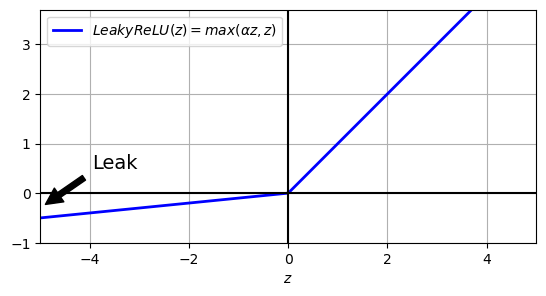

In [3]:
# 1. LeakyReLU

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
fig2, ax2 = plt.subplots()
ax2.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
ax2.plot([-5, 5], [0, 0], 'k-')
ax2.plot([0, 0], [-1, 3.7], 'k-')
ax2.grid(True)
props = dict(facecolor='black', shrink=0.1)
ax2.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
ax2.set_xlabel("$z$")
ax2.axis([-5, 5, -1, 3.7])
ax2.set_aspect("equal")
ax2.legend();

In [4]:
# 2. Keras includes the classes `LeakyReLU` and `PReLU`
#    they should be used with He initialization

leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # default alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [5]:
# 2.1 LeakyReLU can be used as a separate layer
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

2024-03-13 21:04:32.878490: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ELU and SELU
---
- two `smooth` variants of the ReLU
- `exponential linear unit (ELU)`
  - ${\displaystyle ELU_{\alpha}(z) =  {\begin{cases}\alpha \left(e^{z}-1\right)&{\text{if }}z< 0\\z&{\text{if }}z \ge 0\end{cases}}}$
  - If α = 1 then ELU is smooth everywhere
- `scaled ELU (SELU)`
  - ${\displaystyle SELU_{\lambda, \alpha}(z)\lambda {\begin{cases}\alpha (e^{z}-1)&{\text{if }}z<0\\z&{\text{if }}z\geq 0\end{cases}}}$
  - λ=1.0507 and α=1.67326
  - if SELU is used in all hidden layers of an NN with only dense layers
  - then the NN will self-normalize: 
    - the output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, 
    - which solves the vanishing/exploding gradients problem
  - self-normalization needs further conditions below:
    - The input features must be standardized: mean 0 and standard deviation 1
    - Every hidden layer’s weights must be initialized using LeCun normal initialization
    - The self-normalizing property is only guaranteed with plain MLPs
    - You cannot use regularization techniques like $\ell_1$ or $\ell_2$ regularization, max-norm, batch-norm, or regular dropout

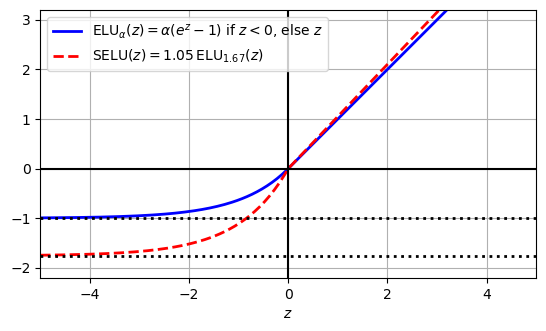

In [7]:
# 1. ELU and SELU

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
fig3, ax3 = plt.subplots()
ax3.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
ax3.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
ax3.plot([-5, 5], [0, 0], 'k-')
ax3.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
ax3.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
ax3.plot([0, 0], [-2.2, 3.2], 'k-')
ax3.grid(True)
ax3.axis([-5, 5, -2.2, 3.2])
ax3.set_xlabel("$z$")
ax3.set_aspect("equal")
ax3.legend();

In [8]:
# 2. apply ELU and SELU
elu_dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

selu_dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

In [18]:
# 3. SELU nn can regularize itself
# 1) create a nn for Fashion MNIST with 100 hidden layers, 
#    using the SELU activation function

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [19]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [20]:
# 2) load and normalize the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [21]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [23]:
# 3) scale the inputs to mean 0 and standard deviation 1 before training the nn
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [24]:
# 4) The network managed to learn, despite it is 100 layers deep
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 19s 10ms/step - loss: 1.0865 - accuracy: 0.5975 - val_loss: 0.7593 - val_accuracy: 0.7320
Epoch 2/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.6823 - accuracy: 0.7576 - val_loss: 0.5958 - val_accuracy: 0.7876
Epoch 3/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.5996 - accuracy: 0.7912 - val_loss: 0.5795 - val_accuracy: 0.8008
Epoch 4/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.5495 - accuracy: 0.8117 - val_loss: 0.5772 - val_accuracy: 0.8178
Epoch 5/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4919 - accuracy: 0.8302 - val_loss: 0.5197 - val_accuracy: 0.8272


In [26]:
# 4) however, same nn with RELU suffers from the vanishing/exploding gradients problem
#   its performance is much worse

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [28]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/5
1719/1719 [==============================] - 17s 9ms/step - loss: 2.0473 - accuracy: 0.1884 - val_loss: 1.8542 - val_accuracy: 0.2338
Epoch 2/5
1719/1719 [==============================] - 15s 9ms/step - loss: 1.5610 - accuracy: 0.3365 - val_loss: 1.1470 - val_accuracy: 0.5184
Epoch 3/5
1719/1719 [==============================] - 15s 9ms/step - loss: 1.1742 - accuracy: 0.4980 - val_loss: 0.9866 - val_accuracy: 0.6020
Epoch 4/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.9674 - accuracy: 0.5990 - val_loss: 0.8934 - val_accuracy: 0.5826
Epoch 5/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.8601 - accuracy: 0.6663 - val_loss: 0.8340 - val_accuracy: 0.6762
